In [ ]:

!pip install tensorflow==2.3.1

Install TensorFlow Quantum:

In [ ]:
!pip install tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [ ]:
!pip install gpustat

In [3]:
import numpy as np
import tensorflow as tf
import time
from keras.utils.np_utils import to_categorical

In [ ]:
# data normalization

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train - np.mean(x_train)
x_test = x_test - np.mean(x_test)


# reshape
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

In [ ]:

class MLP_0():

  # initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))


  # with no hidden layer
  def initialization(self):
          # nums of computing units in each layer
          input_layer=self.sizes[0]
          output_layer=self.sizes[1]
          params = {
              'W0':np.random.randn(output_layer, input_layer) * np.sqrt(1. / output_layer)
          }
          return params

  def forward(self, x_train):
          params = self.params
          params['A0'] = x_train
          # direct from input layer to output layer
          params['A1']=np.dot(params['W0'], params['A0'])
          #softmax at the end of classification
          # note, after I change sigmoid to softmax, the accuracy drops
          params['S1'] =self.softmax(params['A1'])
          return params['S1']


  def backward(self, y_train, output):
          params = self.params
          changes_to_w = {}
          # Calculate W1 update
          error = 2 * (output - y_train) / output.shape[0]  *self.softmax(params['A1'], derivative=True)
          changes_to_w['W0'] = np.outer(error, params['A0'])
          return changes_to_w


  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          
          return np.mean(predictions)


  


In [ ]:
mlp0 = MLP_0(sizes=[784,10])
mlp0.train(x_train,y_train,x_test,y_test)

Epoch: 1, Time Spent: 4.99s, Accuracy: 18.90%
Epoch: 2, Time Spent: 10.02s, Accuracy: 30.85%
Epoch: 3, Time Spent: 15.06s, Accuracy: 43.73%
Epoch: 4, Time Spent: 20.22s, Accuracy: 53.18%
Epoch: 5, Time Spent: 25.36s, Accuracy: 60.16%
Epoch: 6, Time Spent: 30.34s, Accuracy: 65.32%
Epoch: 7, Time Spent: 35.30s, Accuracy: 69.34%
Epoch: 8, Time Spent: 40.22s, Accuracy: 72.47%
Epoch: 9, Time Spent: 45.19s, Accuracy: 75.03%
Epoch: 10, Time Spent: 50.22s, Accuracy: 76.39%
Epoch: 11, Time Spent: 55.10s, Accuracy: 77.99%
Epoch: 12, Time Spent: 60.05s, Accuracy: 79.33%
Epoch: 13, Time Spent: 65.04s, Accuracy: 80.37%
Epoch: 14, Time Spent: 70.06s, Accuracy: 81.50%
Epoch: 15, Time Spent: 75.18s, Accuracy: 82.12%
Epoch: 16, Time Spent: 80.18s, Accuracy: 82.60%
Epoch: 17, Time Spent: 85.17s, Accuracy: 83.04%
Epoch: 18, Time Spent: 90.13s, Accuracy: 83.42%
Epoch: 19, Time Spent: 95.10s, Accuracy: 83.86%
Epoch: 20, Time Spent: 100.05s, Accuracy: 84.33%
Epoch: 21, Time Spent: 105.07s, Accuracy: 84.64%


In [ ]:

class MLP_2():

  # initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))

  def ReLU(self, x, derivative = False):
        if derivative:
          y = x
          y[y <= 0] = 0
          y[y > 0] = 1
          return y
        x[x <= 0] = 0
        return x


  # with one hidden layer
  def initialization(self):
          # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W0':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W1':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W2':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params


  def forward(self, x_train):
        params = self.params
        params['A0'] = x_train
        # from input layer to hidden layer1
        params['A1']=np.dot(params['W0'], params['A0'])
        params['S1'] =self.ReLU(params['A1'])

        # hidden layer1 to hidden layer2
        params['A2'] = np.dot(params["W1"], params['S1'])
        params['S2'] = self.ReLU(params['A2'])

        # hidden layer 2 to output layer
        params['A3'] = np.dot(params["W2"], params['S2'])
        params['S3'] = self.softmax(params['A3'])

        return params['S3']

  def backward(self, y_train, output):
        params = self.params
        changes_to_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['A3'], derivative=True)
        changes_to_w['W2'] = np.outer(error, params['S2'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.ReLU(params['A2'],derivative=True)
        changes_to_w['W1'] = np.outer(error, params['S1'])

        # Calculate W0 update
        error = np.dot(params['W1'].T, error) * self.ReLU(params['A1'],derivative=True)
        changes_to_w['W0'] = np.outer(error, params['A0'])

        return changes_to_w

  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          
          return np.mean(predictions)

In [ ]:
mlp2 = MLP_2(sizes=[784,128,128,10])
mlp2.train(x_train,y_train,x_test,y_test)

Epoch: 1, Time Spent: 44.85s, Accuracy: 75.01%
Epoch: 2, Time Spent: 89.66s, Accuracy: 85.09%
Epoch: 3, Time Spent: 134.74s, Accuracy: 88.15%
Epoch: 4, Time Spent: 179.72s, Accuracy: 89.36%
Epoch: 5, Time Spent: 224.66s, Accuracy: 90.13%
Epoch: 6, Time Spent: 269.50s, Accuracy: 90.71%
Epoch: 7, Time Spent: 314.41s, Accuracy: 91.14%
Epoch: 8, Time Spent: 359.20s, Accuracy: 91.33%
Epoch: 9, Time Spent: 403.93s, Accuracy: 91.62%
Epoch: 10, Time Spent: 448.82s, Accuracy: 91.95%
Epoch: 11, Time Spent: 493.86s, Accuracy: 92.18%
Epoch: 12, Time Spent: 538.70s, Accuracy: 92.32%
Epoch: 13, Time Spent: 583.67s, Accuracy: 92.64%
Epoch: 14, Time Spent: 628.55s, Accuracy: 92.83%
Epoch: 15, Time Spent: 673.24s, Accuracy: 92.97%
Epoch: 16, Time Spent: 718.09s, Accuracy: 93.09%
Epoch: 17, Time Spent: 762.87s, Accuracy: 93.24%
Epoch: 18, Time Spent: 807.60s, Accuracy: 93.38%
Epoch: 19, Time Spent: 852.41s, Accuracy: 93.47%
Epoch: 20, Time Spent: 897.19s, Accuracy: 93.55%
Epoch: 21, Time Spent: 942.19s,

In [5]:

class MLP_2_sigmoid():

  # initialization
  def __init__(self, sizes, epochs=300, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))

  def ReLU(self, x, derivative = False):
        if derivative:
          y = x
          y[y <= 0] = 0
          y[y > 0] = 1
          return y
        x[x <= 0] = 0
        return x


  # with one hidden layer
  def initialization(self):
          # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W0':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W1':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W2':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params


  def forward(self, x_train):
        params = self.params
        params['A0'] = x_train
        # from input layer to hidden layer1
        params['A1']=np.dot(params['W0'], params['A0'])
        params['S1'] =self.sigmoid(params['A1'])

        # hidden layer1 to hidden layer2
        params['A2'] = np.dot(params["W1"], params['S1'])
        params['S2'] = self.sigmoid(params['A2'])

        # hidden layer 2 to output layer
        params['A3'] = np.dot(params["W2"], params['S2'])
        params['S3'] = self.softmax(params['A3'])

        return params['S3']

  def backward(self, y_train, output):
        params = self.params
        changes_to_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['A3'], derivative=True)
        changes_to_w['W2'] = np.outer(error, params['S2'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['A2'],derivative=True)
        changes_to_w['W1'] = np.outer(error, params['S1'])

        # Calculate W0 update
        error = np.dot(params['W1'].T, error) * self.sigmoid(params['A1'],derivative=True)
        changes_to_w['W0'] = np.outer(error, params['A0'])

        return changes_to_w

  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          
          return np.mean(predictions)

In [6]:
mlp2_sig = MLP_2_sigmoid(sizes=[784,128,128,10])
mlp2_sig.train(x_train,y_train,x_test,y_test)

Epoch: 1, Time Spent: 59.98s, Accuracy: 37.68%
Epoch: 2, Time Spent: 119.80s, Accuracy: 41.51%
Epoch: 3, Time Spent: 180.49s, Accuracy: 43.21%
Epoch: 4, Time Spent: 239.86s, Accuracy: 46.96%
Epoch: 5, Time Spent: 300.06s, Accuracy: 52.60%
Epoch: 6, Time Spent: 361.43s, Accuracy: 57.64%
Epoch: 7, Time Spent: 421.95s, Accuracy: 60.65%
Epoch: 8, Time Spent: 481.74s, Accuracy: 62.12%
Epoch: 9, Time Spent: 541.65s, Accuracy: 63.35%
Epoch: 10, Time Spent: 601.75s, Accuracy: 64.55%
Epoch: 11, Time Spent: 661.62s, Accuracy: 65.79%
Epoch: 12, Time Spent: 721.47s, Accuracy: 67.08%
Epoch: 13, Time Spent: 781.41s, Accuracy: 67.83%
Epoch: 14, Time Spent: 841.09s, Accuracy: 68.42%
Epoch: 15, Time Spent: 901.08s, Accuracy: 68.83%
Epoch: 16, Time Spent: 961.81s, Accuracy: 68.97%
Epoch: 17, Time Spent: 1022.42s, Accuracy: 69.10%
Epoch: 18, Time Spent: 1084.08s, Accuracy: 69.38%
Epoch: 19, Time Spent: 1146.12s, Accuracy: 69.77%
Epoch: 20, Time Spent: 1206.87s, Accuracy: 70.17%
Epoch: 21, Time Spent: 126

In [ ]:
class MLP_2_tanh():

# initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))

  def ReLU(self, x, derivative = False):
        if derivative:
          y = x
          y[y <= 0] = 0
          y[y > 0] = 1
          return y
        x[x <= 0] = 0
        return x
  def tanh(self, x, derivative = False):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        dt=1-t**2
        if derivative:
          return dt
        return t


  # with one hidden layer
  def initialization(self):
          # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W0':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W1':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W2':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params


  def forward(self, x_train):
        params = self.params
        params['A0'] = x_train
        # from input layer to hidden layer1
        params['A1']=np.dot(params['W0'], params['A0'])
        params['S1'] =self.tanh(params['A1'])

        # hidden layer1 to hidden layer2
        params['A2'] = np.dot(params["W1"], params['S1'])
        params['S2'] = self.tanh(params['A2'])

        # hidden layer 2 to output layer
        params['A3'] = np.dot(params["W2"], params['S2'])
        params['S3'] = self.softmax(params['A3'])

        return params['S3']

  def backward(self, y_train, output):
        params = self.params
        changes_to_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['A3'], derivative=True)
        changes_to_w['W2'] = np.outer(error, params['S2'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.tanh(params['A2'],derivative=True)
        changes_to_w['W1'] = np.outer(error, params['S1'])

        # Calculate W0 update
        error = np.dot(params['W1'].T, error) * self.tanh(params['A1'],derivative=True)
        changes_to_w['W0'] = np.outer(error, params['A0'])

        return changes_to_w

  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          return np.mean(predictions)

In [ ]:
mlp2_tanh = MLP_2_tanh(sizes=[784,128,128,10])
mlp2_tanh.train(x_train,y_train,x_test,y_test)

Epoch: 1, Time Spent: 55.17s, Accuracy: 83.29%
Epoch: 2, Time Spent: 110.37s, Accuracy: 87.27%
Epoch: 3, Time Spent: 165.68s, Accuracy: 88.49%
Epoch: 4, Time Spent: 221.09s, Accuracy: 89.38%
Epoch: 5, Time Spent: 276.37s, Accuracy: 90.07%
Epoch: 6, Time Spent: 331.61s, Accuracy: 90.67%
Epoch: 7, Time Spent: 386.76s, Accuracy: 91.07%
Epoch: 8, Time Spent: 441.79s, Accuracy: 91.33%
Epoch: 9, Time Spent: 496.89s, Accuracy: 91.58%
Epoch: 10, Time Spent: 551.88s, Accuracy: 91.76%
Epoch: 11, Time Spent: 607.02s, Accuracy: 91.94%
Epoch: 12, Time Spent: 661.96s, Accuracy: 92.08%
Epoch: 13, Time Spent: 716.87s, Accuracy: 92.32%
Epoch: 14, Time Spent: 771.79s, Accuracy: 92.50%
Epoch: 15, Time Spent: 826.98s, Accuracy: 92.62%
Epoch: 16, Time Spent: 882.03s, Accuracy: 92.78%
Epoch: 17, Time Spent: 937.03s, Accuracy: 92.86%
Epoch: 18, Time Spent: 992.16s, Accuracy: 92.97%
Epoch: 19, Time Spent: 1047.29s, Accuracy: 93.11%
Epoch: 20, Time Spent: 1102.28s, Accuracy: 93.19%
Epoch: 21, Time Spent: 1157.

# L2 regularization with ReLU

In [ ]:
import tensorflow as tf

In [ ]:

import tensorflow as tf
from tensorflow import keras

(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
#validation_images = train_images[:5000]
#validation_labels = train_labels[:5000]

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(10, activation='softmax')
])

sgd = keras.optimizers.SGD(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=500)
model.evaluate(test_images, test_labels)

# Ploting performance

## 2 hidden layer with tanh as activation function

[0.833, 0.873, 0.885, 0.894, 0.901, 0.907, 0.911, 0.913, 0.916, 0.918, 0.919, 0.921, 0.923, 0.925, 0.926, 0.928, 0.929, 0.93, 0.931, 0.932, 0.932, 0.934, 0.935, 0.936, 0.937, 0.938, 0.938, 0.939, 0.94, 0.942, 0.942, 0.943, 0.943, 0.943, 0.944, 0.945, 0.946, 0.946, 0.947, 0.947, 0.948, 0.949, 0.949, 0.95, 0.95, 0.95, 0.951, 0.951, 0.951, 0.952, 0.952, 0.953, 0.953, 0.953, 0.954, 0.954, 0.954, 0.955, 0.955, 0.955, 0.955, 0.956, 0.956, 0.956, 0.956, 0.956, 0.957, 0.957, 0.957, 0.957, 0.957, 0.957, 0.958, 0.958, 0.959, 0.959, 0.959, 0.959, 0.959, 0.959, 0.96, 0.959, 0.959, 0.96, 0.96, 0.96, 0.96, 0.96, 0.961, 0.961, 0.961, 0.961, 0.961, 0.961, 0.962, 0.962, 0.962, 0.963, 0.963]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 8

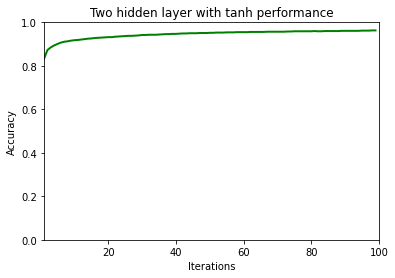

In [ ]:
import matplotlib.pyplot as plt
import xlwt
import os

with open('h2_tanh.txt','r+') as fd:
  e = list(range(1,100))
  p = []
  #read all accuracy from the performance report
  for text in fd.readlines():
    y=text.split(':')[3].strip("\n").strip('%').strip()
    p.append(y.split("\n"))

  p = list(np.concatenate(p).flat)
  p = [round(float(i)/100,3) for i in p]
  print(p)
  print(e)

fd.close()

plt.plot(e, p, color='green',  linewidth = 2)
  
# setting x and y axis range
plt.ylim(0,1)
plt.xlim(1,100)
  
# naming the x axis
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('Two hidden layer with tanh performance')
  
# function to show the plot
plt.show()


## 2 hidden layer with sigmoid as activation function

[0.232, 0.412, 0.493, 0.524, 0.556, 0.584, 0.6, 0.61, 0.623, 0.636, 0.647, 0.652, 0.655, 0.657, 0.657, 0.656, 0.657, 0.658, 0.66, 0.664, 0.669, 0.677, 0.685, 0.695, 0.704, 0.714, 0.721, 0.729, 0.735, 0.743, 0.75, 0.755, 0.758, 0.763, 0.765, 0.768, 0.77, 0.772, 0.774, 0.776, 0.778, 0.779, 0.782, 0.786, 0.791, 0.795, 0.798, 0.803, 0.805, 0.807, 0.807, 0.809, 0.81, 0.81, 0.81, 0.812, 0.812, 0.812, 0.812, 0.812, 0.812, 0.814, 0.813, 0.813, 0.814, 0.814, 0.815, 0.815, 0.816, 0.816, 0.816, 0.817, 0.817, 0.817, 0.818, 0.818, 0.818, 0.818, 0.818, 0.819, 0.819, 0.819, 0.82, 0.821, 0.824, 0.828, 0.833, 0.841, 0.847, 0.853, 0.86, 0.866, 0.871, 0.874, 0.877, 0.879, 0.88, 0.881, 0.883, 0.884]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,

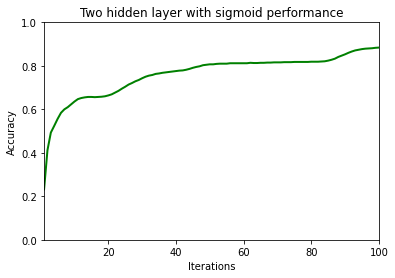

In [ ]:
with open('sig.txt','r+') as fd:
  e = list(range(1,101))
  p = []
  #read all accuracy from the performance report
  for text in fd.readlines():
    y=text.split(':')[3].strip("\n").strip('%').strip()
    p.append(y.split("\n"))

  p = list(np.concatenate(p).flat)
  p = [round(float(i)/100,3) for i in p]
  print(p)
  print(e)

fd.close()

plt.plot(e, p, color='green',  linewidth = 2)
  
# setting x and y axis range
plt.ylim(0,1)
plt.xlim(1,100)
  
# naming the x axis
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('Two hidden layer with sigmoid performance')
  
# function to show the plot
plt.show()

## 2 hidden layer with RELU as activation function

[0.75, 0.851, 0.882, 0.894, 0.901, 0.907, 0.911, 0.913, 0.916, 0.919, 0.922, 0.923, 0.926, 0.928, 0.93, 0.931, 0.932, 0.934, 0.935, 0.935, 0.937, 0.937, 0.938, 0.939, 0.939, 0.94, 0.941, 0.941, 0.942, 0.942, 0.943, 0.943, 0.944, 0.944, 0.945, 0.946, 0.946, 0.946, 0.946, 0.947, 0.948, 0.948, 0.948, 0.948, 0.948, 0.949, 0.949, 0.949, 0.949, 0.95, 0.95, 0.95, 0.95, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.953, 0.953, 0.953, 0.953, 0.953, 0.953, 0.953, 0.953, 0.953, 0.954, 0.954, 0.954, 0.955, 0.955, 0.955, 0.955, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.957, 0.957, 0.957, 0.957, 0.957, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.957, 0.957]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79

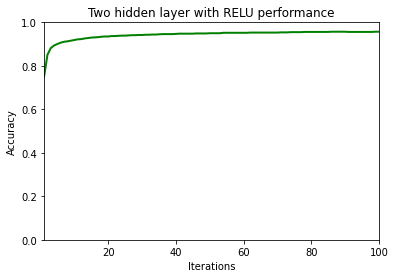

In [ ]:
with open('h2_relu.txt','r+') as fd:
  e = list(range(1,101))
  p = []
  #read all accuracy from the performance report
  for text in fd.readlines():
    y=text.split(':')[3].strip("\n").strip('%').strip()
    p.append(y.split("\n"))

  p = list(np.concatenate(p).flat)
  p = [round(float(i)/100,3) for i in p]
  print(p)
  print(e)

fd.close()

plt.plot(e, p, color='green',  linewidth = 2)
  
# setting x and y axis range
plt.ylim(0,1)
plt.xlim(1,100)
  
# naming the x axis
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('Two hidden layer with RELU performance')
  
# function to show the plot
plt.show()